In [1]:
import pandas as pd
from variants_compare import VariantsCompare
from pm4py.objects.conversion.log import converter as log_converter
from algorithm_ranking import MeasurementsVisualizer, MeasurementsManager, RankVariantsDFGTr, RankVariantsSort2
import random
from am4pa.data_proccessing import CaseDurationsManager

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import random

In [3]:
ct = pd.read_csv('saved-data/GLS_1000_100/ct_competing_variants.csv', index_col=[0])
alg_list = list(ct['case:concept:name'])
alg_list

['algorithm8',
 'algorithm2',
 'algorithm17',
 'algorithm53',
 'algorithm54',
 'algorithm58',
 'algorithm62',
 'algorithm66',
 'algorithm99',
 'algorithm88']

In [4]:
et = pd.read_csv('saved-data/GLS_1000_100/run_times_competing_1.csv',sep=';')
et['case:variant'] = et['case:concept:name'].apply(lambda row: row.split('_')[0])
et = et[et['case:variant'].isin(alg_list)]
cm = CaseDurationsManager()
cm.add_case_durations(et)

In [5]:
def rename_algs(alg_mes):
    new_alg_mes = {}
    l = [int(k.split('algorithm')[-1]) for k in list(alg_mes.keys())]
    l.sort()
    for i, alg in enumerate(l):
        new_alg_mes['alg{}'.format(i)] = alg_mes['algorithm{}'.format(alg)].copy()
    return new_alg_mes        

In [6]:
new_alg_mes = rename_algs(cm.get_alg_measurements())
alg_list = list(new_alg_mes.keys())

In [7]:
def sample_vals(alg_mes,n, seed=1001):
    random.seed(seed)
    alg_mes_sample = {}
    for k,v in alg_mes.items():
        alg_mes_sample[k] = random.sample(v,n)
    return alg_mes_sample

In [8]:
alg_mes_sample = sample_vals(new_alg_mes, 2, seed=122)
#alg_mes_sample

In [9]:
mv = MeasurementsVisualizer(alg_mes_sample, alg_list)

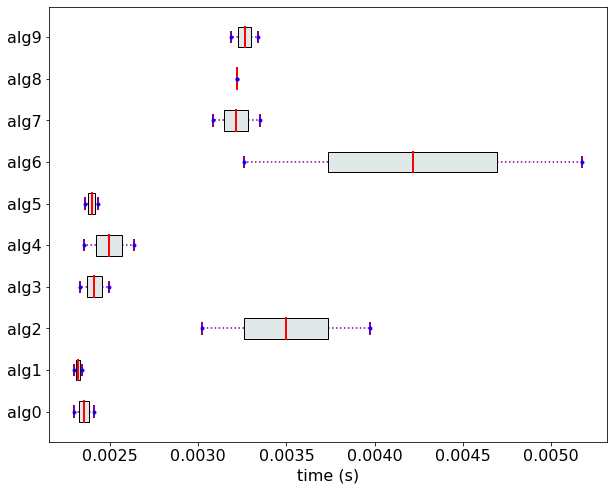

In [10]:
fig = mv.show_measurements_boxplots(scale=0.8,tick_size=16)

In [11]:
fig.savefig("gls-1000-100-sample-box.pdf", format="pdf", bbox_inches="tight")

In [12]:
ct

,case:concept:name,case:flops,case:num_kernels,case:rank:q75-q25
0,algorithm8,445000000.0,8,0
1,algorithm2,445000000.0,8,0
2,algorithm17,447000000.0,8,1
3,algorithm53,455000000.0,8,0
4,algorithm54,455000000.0,8,0
5,algorithm58,455000000.0,8,0
6,algorithm62,456000000.0,10,1
7,algorithm66,456000000.0,10,1
8,algorithm99,466000000.0,10,1
9,algorithm88,466000000.0,10,1


In [13]:
rv = RankVariantsSort2(alg_mes_sample, alg_list)

In [14]:
rv.sort_h0_by_iqr()

,algs,iqr
8,alg8,4.768372e-07
1,alg1,2.300739e-05
5,alg5,3.850460e-05
0,alg0,5.507469e-05
9,alg9,7.545948e-05
3,alg3,8.046627e-05
7,alg7,1.338720e-04
4,alg4,1.441240e-04
2,alg2,4.769564e-04
6,alg6,9.580851e-04


In [15]:
ranks = rv.rank_variants()
ranks.sort_values(by='case:concept:name')

,case:concept:name,case:rank:q75-q25
2,alg0,1
0,alg1,0
8,alg2,3
3,alg3,1
4,alg4,1
1,alg5,1
9,alg6,4
7,alg7,3
5,alg8,2
6,alg9,3


In [16]:
rv2 = RankVariantsDFGTr(alg_mes_sample, alg_list)

In [17]:
rv2.rank_variants().sort_values(by='case:concept:name')

,case:concept:name,case:rank:q75-q25
0,alg0,0
1,alg1,0
7,alg2,4
2,alg3,1
4,alg4,2
3,alg5,1
9,alg6,5
5,alg7,3
6,alg8,3
8,alg9,4


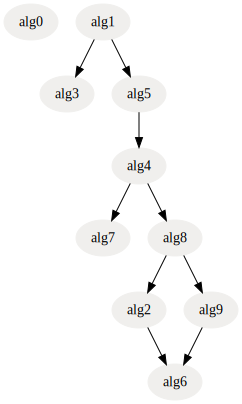

In [18]:

rv2.graph.transitivity_reduction()
rv2.graph.visualize()

In [19]:
rv2.graph.get_separable_arrangement()

['alg1',
 'alg0',
 'alg5',
 'alg3',
 'alg4',
 'alg8',
 'alg7',
 'alg2',
 'alg9',
 'alg6']

In [20]:
rv.alg_seq_h0 = rv2.graph.get_separable_arrangement()

In [21]:
rv.rank_variants().sort_values(by='case:concept:name')

,case:concept:name,case:rank:q75-q25
1,alg0,0
0,alg1,0
7,alg2,1
3,alg3,0
4,alg4,0
2,alg5,0
9,alg6,2
6,alg7,1
5,alg8,1
8,alg9,1


In [22]:
def clean_concept(name):
    splits = name.split('=')
    if len(splits) > 1:
        return splits[-1].strip()
    return splits[0].strip()

et['concept:name'] = et['concept:name'].apply(lambda row: clean_concept(row))

In [23]:
xes_log = log_converter.apply(et)
best = ranks[ranks['case:rank:q75-q25']==0]['case:concept:name'].tolist()
worst = ranks[ranks['case:rank:q75-q25']==1]['case:concept:name'].tolist()
worst = ['algorithm17']

In [24]:
activity_key = 'concept:name'
#activity_key = 'concept:operation'

In [25]:
vc = VariantsCompare(xes_log,best,worst,activity_key=activity_key, variants_id_key="variant")

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


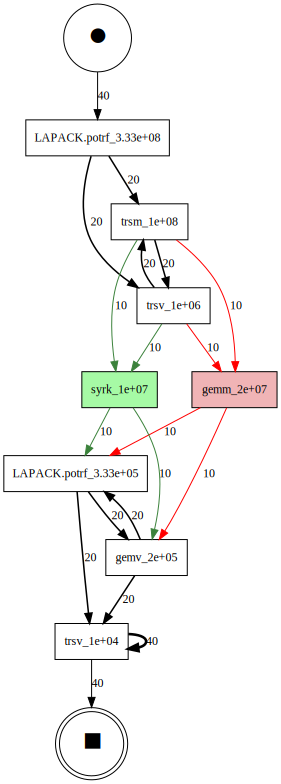

In [30]:
gviz = vc.get_dfg_minus_best_worst(orientation='TD')
gviz

In [31]:
gviz.render(filename='gviz/gls-1000-100-f', format='pdf')

'gviz/gls-1000-100-f.pdf'

In [32]:
best = ['algorithm2', 'algorithm8']
worst = ['algorithm53','algorithm58' ]
vc = VariantsCompare(xes_log,best,worst,activity_key=activity_key, variants_id_key="variant")

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


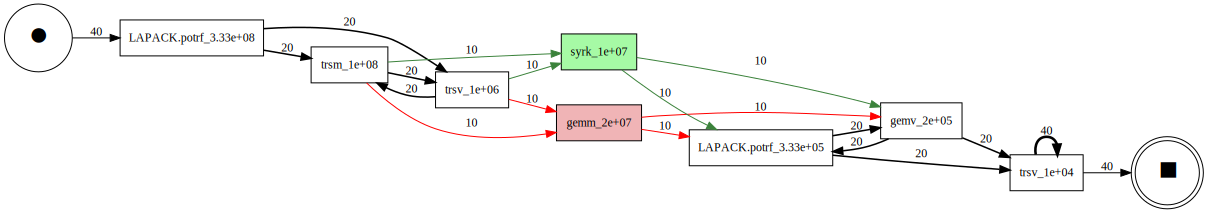

In [33]:
gviz = vc.get_dfg_minus_best_worst(orientation='LR')
gviz

In [34]:
gviz.render(filename='gviz/gls-1000-100', format='svg')

'gviz/gls-1000-100.svg'

In [35]:
best = ['algorithm58','algorithm53']
worst = ['algorithm54' ]
vc = VariantsCompare(xes_log,best,worst,activity_key=activity_key, variants_id_key="variant")

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


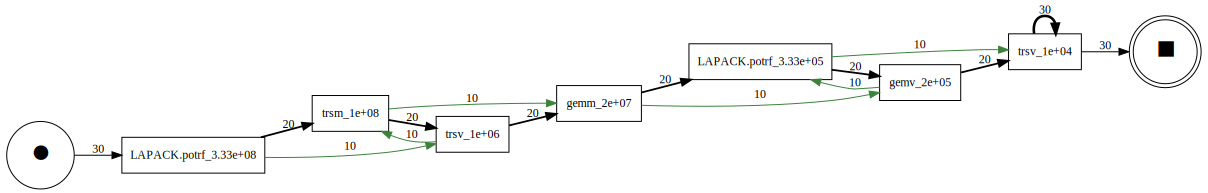

In [36]:
gviz = vc.get_dfg_minus_best_worst(orientation='LR')
gviz

In [37]:
gviz.render(filename='gviz/gls-1000-100-g', format='pdf')

'gviz/gls-1000-100-g.pdf'

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


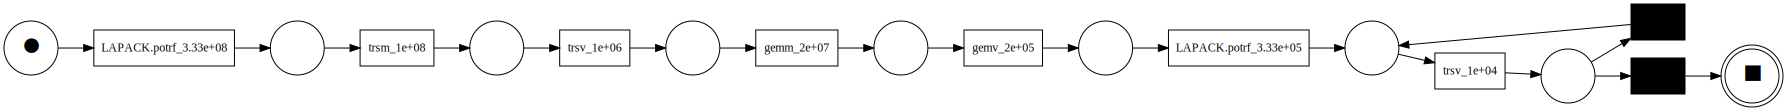

In [38]:
vc.show_petrinet(variants_list=['algorithm58'])